# First order reversible reaction kinetics

In this notebook, we are going to consider a system where we have a simple first order equilibrium as shown below.

$$ A \rightleftarrows B $$

For this type of reaction, the series or ordinary differential equations is slightly more complex than our irreversible case. 

$$ \frac{d[A]}{dt} = -k_{1}[A] + k_{-1}[B]$$
$$ \frac{d[B]}{dt} = k_{1}[A] - k_{-1}[B]$$

The difference between these differential equations and the ones for an irreversible first order reaction are the terms $k_{-1}[B]$ for the reverse reaction, which use $k_{-1}$ to designate the reverse rate constant. In each equation, these terms represent the regeneration of *A* or the removal *B*, respecitively.

Integration of these differential equations is more complicated, but [it can be done](https://chem.libretexts.org/Textbook_Maps/Physical_and_Theoretical_Chemistry_Textbook_Maps/Map%3A_Physical_Chemistry_for_the_Biosciences_%28Chang%29/09%3A_Chemical_Kinetics/9.04%3A_More_Complex_Reactions) to give the following analytical solution:

$$ [A] = [A]_{eq} + ([A]_0 - [A]_{eq})e^{-(k_1 + k_{-1})*t} $$

In this case, $[A]_{eq}$ is the concentration of *A* at equilibrium, and $[A]_0$ is the starting concentration of *A*. An obvious problem with this solution is that the sum of rate constants, $k_1 + k_{-1}$, is used. This means that fitting observed kinetic data using this equation is going to give the sum of both rate constants. However, if one were to measure the final equilibrium constant for the reaction, $K_{eq}$, you could get each rate constant using the relationship $K_{eq} = \frac{k_1}{k_{-1}}$.

As before, we need to start out by importing all of the necessary modules.

In [1]:
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo

In [2]:
from ODEnlls import ODEnlls

For this example, we'll use some real-world reaction data that was collected for the self-metathesis of propene in the gas phase. Alkene metatheses are reversible reactions that effectively "swap" the substituents on the double bond. In the case of the self-metathesis of propene, we can write the following chemical reaction:

$$ Propene + Propene \rightleftarrows Ethene + 2{\text -}Butene$$

In this case, *2-Butene* can be either the *cis* or more thermodynamically stable *trans* isomer. Obviously, this should be a second order reaction; however, the details of this reaction are more complicated. This reaction requires a catalyst, which is not shown. If we assume that the amount of catalyst is very small and constant, we can approximate this process as a series of first-order equilibria as follows:

$$ Propene \rightleftarrows Ethene $$
$$ Propene \rightleftarrows cis{\text -}2{\text -}Butene $$
$$ Propene \rightleftarrows trans{\text -}2{\text -}Butene $$

Then for this total system, we will need four concentrations and six equilibrium constants (three forward and three reverse).

To get started, let's load the data to see what it looks like. The data is stored in a plain-text CSV file, and for convinience, we'll use the `pandas.read_csv` function to create a DataFrame table of data.

In [3]:
eq_data = pd.read_csv('prodata.txt', comment='#')
eq_data

,Time,Ethene,Propene,trans2Butene,cis2Butene
0,0.67,3.18,161.95,1.44,1.47
1,2.17,10.57,148.96,5.12,3.41
2,3.67,15.17,138.48,9.57,4.79
3,5.17,18.24,131.83,12.59,5.35
4,6.67,20.30,127.44,14.79,5.48
5,8.67,22.35,123.37,16.60,5.69
6,11.18,23.57,120.45,18.23,5.74
7,14.18,24.52,118.43,19.33,5.72
8,19.25,25.46,116.82,20.07,5.65
9,24.32,25.62,116.33,20.41,5.64


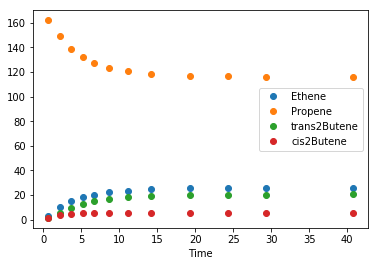

In [4]:
eq_data.plot(x='Time', style='o')

## Using analytical solutions

Again, let's write a function that returns the analytical solution to the first order reversible reaction for any given time.

In [5]:
def first_order_rev(times, c_A0, c_Aeq, k):
    return c_Aeq + (c_A0 - c_Aeq)*np.exp(-k*times)

And here's a simple simulation of what this function looks like for some guess parameters.

(0, 102.49988650017559)

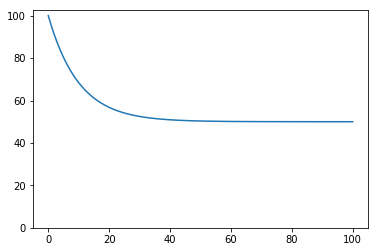

In [6]:
times = np.linspace(0, 100, 1000)
A0_guess = 100
Aeq_guess = 50
k_guess = 0.1

plt.plot(times, first_order_rev(times, A0_guess, Aeq_guess, k_guess))
plt.ylim(ymin=0)

We can use this function for fitting our data, but it will only work for our Propene data, because it is the only starting material. Extract this data from the DataFrame. 

In [7]:
obs_t = eq_data['Time']
obs_c = eq_data['Propene']

Adn again, we'll fit this data using our standard non-linear least squares function `curve_fit`. 

In [8]:
fit, cov = spo.curve_fit(first_order_rev, obs_t, obs_c, 
              p0=(A0_guess, Aeq_guess, k_guess))

Here's the final fit parameters and the associated errors.

In [9]:
sigma = np.sqrt(np.diag(cov))

print('Fit params:', fit)
print('Fit errors:', sigma)

Fit params: [ 169.79437061  116.14911093    0.23355659]
Fit errors: [ 0.41621641  0.15785117  0.00345863]


The parameters and errors look okay, but it is always a good idea to plot the results and the residuals to check that things really are okay. In this case, the residual plot shows some non-random structure, which may indicate that a different model is appropriate. This is most likely due to the assumptions we made earlier about the system; unfortunately, it will be very difficult to generate analytical solutions to a more complete system of differential equations.

(0.0, 164.33282948929704)

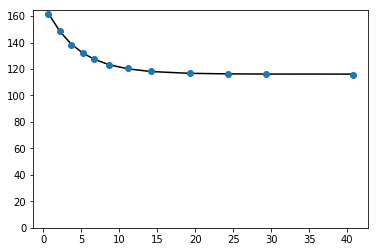

In [10]:
plt.plot(obs_t, first_order_rev(obs_t, *fit), 'k-')
plt.plot(obs_t, obs_c, 'o')
plt.ylim(ymin=0.)

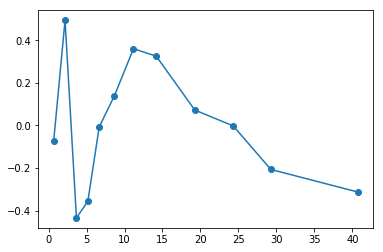

In [11]:
plt.plot(obs_t, obs_c-first_order_rev(obs_t, *fit), 'o-')

## Using ODEnlls to fit one compound data set

We can attempt the same fit using **ODEnlls**. First of all, load in the data using the `read_data` method. In this case, we only want the 'Time' and 'Propene' columns. Remember that this method is simply a wrapper for `pandas.read_csv`, so we can use some of the [keyword arguments for that function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) to select the appropriate data.

In [12]:
x = ODEnlls()
x.read_data('prodata.txt', comment='#', usecols=['Time', 'Propene'])
x.data

,Time,Propene
0,0.67,161.95
1,2.17,148.96
2,3.67,138.48
3,5.17,131.83
4,6.67,127.44
5,8.67,123.37
6,11.18,120.45
7,14.18,118.43
8,19.25,116.82
9,24.32,116.33


We'll also need to load a reaction that we want to use for ODE simulation. In this case, we are assuming this is a first-order reversible reaction. We only care about "Propene", so the product of the reaction is just a generic "products" placeholder.

In [13]:
rxn = 'Propene = products'
f = io.StringIO('w+')
f.write(rxn)
f.seek(0)

x.read_rxns(f)
x.rxns

['Propene = products']

In [14]:
x.odes

['1.00*(-1*k1*(Propene) + k2*(products))',
 '1.00*(k1*(Propene) + -1*k2*(products))']

In [15]:
x.params

,guess,fix
Propene,NaN,NaN
products,NaN,NaN
k1,NaN,NaN
k2,NaN,NaN


Here we'll set our fit parameters. Unlike the analytical solution, there is no $[A]_{eq}$; however, we do have to define both rate constants instead. We will assume that we start with no products, and make sure that this parameter is fixed. (We don't have any "products" data to fit this parameter to anyway, so we have to fix it no matter what.)

In [16]:
x.set_param('Propene', A0_guess)
x.set_param('k1', k_guess)
x.set_param('k2', k_guess)

x.set_param('products', 0.0, ptype='fix')

In [17]:
x.params

,guess,fix
Propene,100.0,NaN
products,NaN,0.0
k1,0.1,NaN
k2,0.1,NaN


Because our rate constants are identical, our equilibrium should result in equal amounts of Propene and products. (I.e. the equilibrium constant is equal to 1.)

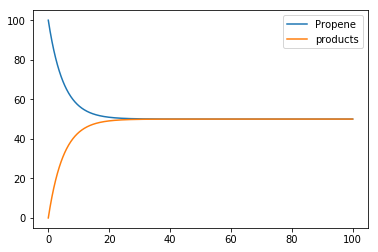

In [18]:
x.plot('sim', colorlines=True)

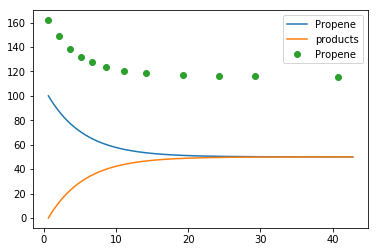

In [19]:
x.plot('guess', colorlines=True)

After fitting the data, we see that our ODEnlls fit is visually idential to the fit we got with the analytical equation.

In [20]:
x.run_fit()

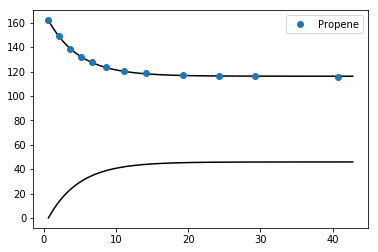

In [21]:
x.plot('fit')

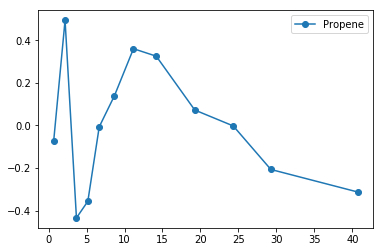

In [22]:
x.plot('res')

We can compare the new fit parameters to the fit parameters we got from the analytical equation, which for reference are as follows:

    Fit params: [ 169.79437061  116.14911093    0.23355659]
    Fit errors: [ 0.41621641  0.15785117  0.00345863]

In [23]:
x.params

,guess,fix,fit,error
Propene,100.0,NaN,162.023652,0.292921
products,NaN,0.0,0.000000,NaN
k1,0.1,NaN,0.066128,0.001062
k2,0.1,NaN,0.167429,0.002481


These numbers are quite a bit different, but there are couple of things to keep in mind.

1. ODEnlls fits the data starting at the first time point, which in this case is *not* 0. That means that the fitted value for Propene is the concentration at the first time point in the data set, which is 0.67.
2. The $k$ value in the analytical solution is the sum of both rate constants. We can easily sum the rate constants from the ODEnlls fit, but we can't sum the errors directly. We can sum the variances, though, so a solution will be to do the following:
$$ error_{k_1 + k_2} = \sqrt{error_{k_1}^2 + error_{k_2}^2}$$

As we can see, the sum of k values is essentially idential but the error is slightly smaller.

In [24]:
print('k sum:', x.params.loc[['k1', 'k2'], 'fit'].sum())
print('k error:', np.sqrt((x.params.loc[['k1', 'k2'], 'error']**2).sum()))

k sum: 0.233556695749
k error: 0.00269831749409


## Using ODEnlls to fit entire data set

The fitting examples we've seen so far have all been soluble using analytical solutions to the differential equations. Where **ODEnlls** excels over fitting using conventional analytical solutions, though, is that you can define a complete sytem of chemical reactions, which means that you can simultaneously fit an entire data set for all concentrations. 

As an example, let's do a fit of the complete data set from this reaction.

In [25]:
x = ODEnlls()
x.read_data('prodata.txt', comment='#')
x.data

,Time,Ethene,Propene,trans2Butene,cis2Butene
0,0.67,3.18,161.95,1.44,1.47
1,2.17,10.57,148.96,5.12,3.41
2,3.67,15.17,138.48,9.57,4.79
3,5.17,18.24,131.83,12.59,5.35
4,6.67,20.30,127.44,14.79,5.48
5,8.67,22.35,123.37,16.60,5.69
6,11.18,23.57,120.45,18.23,5.74
7,14.18,24.52,118.43,19.33,5.72
8,19.25,25.46,116.82,20.07,5.65
9,24.32,25.62,116.33,20.41,5.64


The complete set of reactions is the three first-order reversible reactions that we defined at the beginning of this notebook.

In [26]:
x.read_rxns('prorxn.txt')
x.rxns

['Propene = Ethene', 'Propene = cis2Butene', 'Propene = trans2Butene']

In [27]:
x.params

,guess,fix
Propene,NaN,NaN
Ethene,NaN,NaN
cis2Butene,NaN,NaN
trans2Butene,NaN,NaN
k1,NaN,NaN
k2,NaN,NaN
k3,NaN,NaN
k4,NaN,NaN
k5,NaN,NaN
k6,NaN,NaN


For this fit, it turns out that we can set all of the guess parameters for the fit as zero. (This only works for this particular example. In other cases, you will most likely need to play around with the starting values to get a meaningful fit.)

In [28]:
x.params['guess'] = 0.0
x.params

,guess,fix
Propene,0.0,NaN
Ethene,0.0,NaN
cis2Butene,0.0,NaN
trans2Butene,0.0,NaN
k1,0.0,NaN
k2,0.0,NaN
k3,0.0,NaN
k4,0.0,NaN
k5,0.0,NaN
k6,0.0,NaN


In [29]:
x.run_fit()

After funning the fit, we can see that we've got reasonable fit parameters for all of our reactions. 

In [30]:
x.params

,guess,fix,fit,error
Propene,0.0,NaN,162.151714,0.221074
Ethene,0.0,NaN,3.521668,0.210429
cis2Butene,0.0,NaN,1.463520,0.222220
trans2Butene,0.0,NaN,0.872110,0.204150
k1,0.0,NaN,0.036267,0.000639
k2,0.0,NaN,0.164353,0.003376
k3,0.0,NaN,0.013267,0.001120
k4,0.0,NaN,0.275604,0.025469
k5,0.0,NaN,0.025251,0.000500
k6,0.0,NaN,0.140921,0.003375


In addition, the fit plots look like they match very well with our intut data, and the residuals all seem to be reasonable.

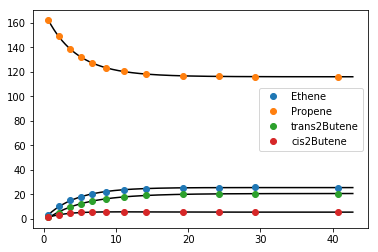

In [31]:
x.plot('fit')

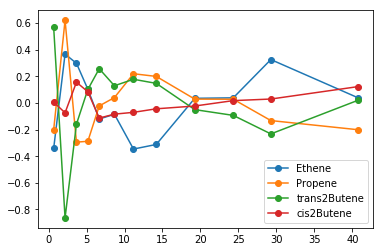

In [32]:
x.plot('res')